In [2]:
from app import app, db, bcrypt
from models import User, Stock, Portfolio
from flask import jsonify, request
import pandas as pd
import sqlite3

import numpy as np
import statistics

In [3]:
data = [
  {
    "date": "Sat, 01 Mar 2025 00:00:00 GMT",
    "id": 2,
    "purchase_price": 1600.0,
    "quantity": 10,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Sat, 01 Feb 2025 00:00:00 GMT",
    "id": 3,
    "purchase_price": 2200.0,
    "quantity": 20,
    "symbol": "HINDUNILVR.NS"
  },
  {
    "date": "Tue, 04 Mar 2025 00:00:00 GMT",
    "id": 4,
    "purchase_price": 3500.0,
    "quantity": 30,
    "symbol": "TCS.NS"
  },
  {
    "date": "Fri, 04 Aug 2023 00:00:00 GMT",
    "id": 5,
    "purchase_price": 900.0,
    "quantity": 10,
    "symbol": "BBTC.NS"
  },
  {
    "date": "Sat, 01 Feb 2025 00:00:00 GMT",
    "id": 6,
    "purchase_price": 1200.0,
    "quantity": 20,
    "symbol": "BALKRISIND.NS"
  },
  {
    "date": "Tue, 10 Sep 2019 00:00:00 GMT",
    "id": 12,
    "purchase_price": 1400.0,
    "quantity": 90,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Wed, 19 May 2021 00:00:00 GMT",
    "id": 13,
    "purchase_price": 1500.0,
    "quantity": 30,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Wed, 08 Feb 2023 00:00:00 GMT",
    "id": 14,
    "purchase_price": 1450.0,
    "quantity": 70,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Wed, 08 Feb 2023 00:00:00 GMT",
    "id": 15,
    "purchase_price": 2450.0,
    "quantity": 70,
    "symbol": "HINDUNILVR.NS"
  },
  {
    "date": "Thu, 11 Mar 2021 00:00:00 GMT",
    "id": 16,
    "purchase_price": 2150.0,
    "quantity": 90,
    "symbol": "HINDUNILVR.NS"
  },
  {
    "date": "Wed, 10 Jul 2019 00:00:00 GMT",
    "id": 17,
    "purchase_price": 3000.0,
    "quantity": 60,
    "symbol": "TCS.NS"
  },
  {
    "date": "Tue, 11 Mar 2025 00:00:00 GMT",
    "id": 18,
    "purchase_price": 1400.0,
    "quantity": 40,
    "symbol": "BALKRISIND.NS"
  },
  {
    "date": "Tue, 11 Mar 2025 00:00:00 GMT",
    "id": 19,
    "purchase_price": 1400.0,
    "quantity": 40,
    "symbol": "BALKRISIND.NS"
  }
]


In [28]:
import sys
import json
import sqlite3
from datetime import datetime, date, timedelta

#data_input = sys.argv[1]

# start and end date
startDate = date.today() - timedelta(days=365)
endDate = date.today()

# Factory Pattern for Trade Creation
class Trade:
    def __init__(self, id, symbol, purchase_price, quantity, date):
        self.id = id
        self.symbol = symbol
        self.purchase_price = purchase_price
        self.quantity = quantity
        self.date = datetime.strptime(date, '%a, %d %b %Y %H:%M:%S %Z')

    def __str__(self):
        return f"Trade(symbol={self.symbol}, purchase_price={self.purchase_price})"

    def lastPrice(self):
        return PortfolioValueProvider().get_asset_value(self.symbol,"Close", startDate, endDate)

    def totalValueNew(self):
        return self.quantity * self.lastPrice()


class TradeFactory:
    def create_trade(self, id, symbol, purchase_price, quantity, date):
        return Trade(id, symbol, purchase_price, quantity, date)


# Portfolio Class with Aggregation and API Interaction
class Portfolio:
    def __init__(self):
        self.trades = []
        self.value_provider = PortfolioValueProvider()
        self.net_values = None  # Store the calculated net values
        self.portfolio_status = {}  # Store the portfolio's status for each date

    def add_trade(self, trade):
        self.trades.append(trade)
        self.update_portfolio_status()

    def add_trades(self, trade_data):
        trade_factory = TradeFactory()
        for trade_info in trade_data:
            self.trades.append(trade_factory.create_trade(**trade_info))
        self.update_portfolio_status()

    def calculate_net(self):
        if self.net_values is None:
            net_value = {}
            total_quantity = {}
            average_price = {}
            current_value = {}
            for trade in self.trades:
                if trade.symbol in net_value:
                    net_value[trade.symbol] += trade.quantity * trade.purchase_price
                    total_quantity[trade.symbol] += trade.quantity
                    average_price[trade.symbol] = net_value[trade.symbol] / total_quantity[trade.symbol]
                    current_value[trade.symbol] = total_quantity[trade.symbol] * self.value_provider.get_asset_value(
                        trade.symbol, "Close", startDate, endDate)
                else:
                    net_value[trade.symbol] = trade.quantity * trade.purchase_price
                    total_quantity[trade.symbol] = trade.quantity
                    average_price[trade.symbol] = net_value[trade.symbol] / total_quantity[trade.symbol]
                    current_value[trade.symbol] = total_quantity[trade.symbol] * self.value_provider.get_asset_value(
                        trade.symbol, "Close", startDate, endDate)
            self.net_values = net_value, total_quantity, average_price, current_value

        return self.net_values

    def calculate_current_value(self, currency):
        current_value = {}
        for trade in self.trades:
            currency_converter = 1
            asset_value = self.value_provider.get_asset_value(trade.symbol, "Close", startDate, trade.date)
            if asset_value is not None:
                current_value[trade.symbol] = asset_value * trade.quantity * currency_converter
        return current_value

    def update_portfolio_status(self):
        for trade in self.trades:
            if trade.date not in self.portfolio_status:
                self.portfolio_status[trade.date] = {}

            if trade.symbol not in self.portfolio_status[trade.date]:
                self.portfolio_status[trade.date][trade.symbol] = trade.quantity
            else:
                self.portfolio_status[trade.date][trade.symbol] += trade.quantity

    def get_portfolio_status_by_date(self, date):
        return self.portfolio_status.get(date, {})

    def get_portfolio_status_for_dates(self, dates):
        portfolio_status_for_dates = []

        for date in dates:
            portfolio_status_for_dates.append({
                'date': date,
                'assets_quantity': self.get_portfolio_status_by_date(date)
            })

        return portfolio_status_for_dates

    def calculate_daily_values_oneyear(self, currency):
        daily_values = []
        trade_dates = []
        stock_quantity = {}
        start_dt = startDate
        end_dt = endDate
        delta = timedelta(days=1)

        # store the dates between two dates in a list
        dates_oneyear = []

        while start_dt <= end_dt:
            dates_oneyear.append(start_dt.isoformat())
            start_dt += delta

        sorted_trades = sorted(self.trades, key=lambda trade: trade.date)
        for date in dates_oneyear:
            total_value_for_date = 0
            for trade in sorted_trades:
                if trade.date == date:
                    total_value_for_date += trade.quantity * self.value_provider.get_asset_value(trade.symbol, date)
            daily_values.append(total_value_for_date)

        portfolio_status = self.get_portfolio_status_for_dates(dates_oneyear)

        return portfolio_status, dates_oneyear

    def assets_on_dates_oneyear(self):
        dates_oneyear = []
        start_dt = startDate
        end_dt = endDate
        delta = timedelta(days=1)

        while start_dt <= end_dt:
            dates_oneyear.append(start_dt.isoformat())
            start_dt += delta

        assets_by_date = {}

        trade_dates_set = set(trade.date for trade in self.trades)
        sorted_trades = sorted(self.trades, key=lambda trade: trade.date)

        for date1 in dates_oneyear:
            assets_on_date = {}
            date1_dt = datetime.fromisoformat(date1)  # Convert date1 to datetime object
            for trade in self.trades:
                if trade.date <= date1_dt:
                    if trade.symbol in assets_on_date:
                        assets_on_date[trade.symbol] += trade.quantity
                    else:
                        assets_on_date[trade.symbol] = trade.quantity
            assets_by_date[date1] = assets_on_date

        return assets_by_date

    @staticmethod
    def portfolio_value_for_dates(portfolio_dict, currency):
        stock_data = {}
        value_provider = PortfolioValueProvider()
        #startDate = date.today() - timedelta(days=365)
        #endDate = date.today()

        for date_str, stocks in portfolio_dict.items():
            date_obj = datetime.strptime(date_str, '%Y-%m-%d').date()  # Convert date string to date object
            for stock_name in stocks.keys():
                if stock_name not in stock_data:
                    stock_data[stock_name] = value_provider.get_asset_values(stock_name, "Close", startDate, endDate)

        portfolio_value_by_dates = {}

        for date_str, stocks in portfolio_dict.items():
            # Convert date string to datetime object with time set to midnight
            date_obj = datetime.strptime(date_str, '%Y-%m-%d')
            date_key = date_obj.strftime('%Y-%m-%d %H:%M:%S')  # Format to match stock_history keys
            total_value = 0

            for stock_name, quantity in stocks.items():
                stock_history = stock_data[stock_name]

                if date_key in stock_history:
                    stock_value = stock_history[date_key] * quantity
                    total_value += stock_value

            if total_value > 0:
                portfolio_value_by_dates[date_str] = total_value
        return portfolio_value_by_dates

    def calculate_risk_metrics(self, price_array, portfolio_value):
            risk_metrics = RiskMetrics(price_array, portfolio_value)
            monte_carlo_var_dollar, simulated_returns = risk_metrics.monte_carlo_var()
            return {
                "mean": risk_metrics.mean(),
                "variance": risk_metrics.variance(),
                "std_dev": risk_metrics.standard_deviation(),
                "max": risk_metrics.max_price(),
                "min": risk_metrics.min_price(),
                "sharpe_ratio": risk_metrics.sharpe_ratio(),
                "sortino_ratio": risk_metrics.sortino_ratio(),
                "value_at_risk": risk_metrics.value_at_risk(),
                "value_at_risk_dollar": risk_metrics.value_at_risk_dollar(),
                "monte_carlo_var": monte_carlo_var_dollar,
                "monte_carlo_simulated_returns": simulated_returns.tolist(),  # For histogram
                "rolling_std_dev": risk_metrics.rolling_std_dev()  # For volatility chart
            }





# Data Collection
class PortfolioValueProvider:
    def __init__(self):
        self.conn = sqlite3.connect('stock_data.db')
        self.cursor = self.conn.cursor()


    def get_asset_value(self, symbol, metric, startDate, endDate):
        query = """
        SELECT d.value
        FROM Data d
        JOIN Companies c ON d.Company_ID = c.Company_ID
        JOIN Metrics m ON d.Metric_ID = m.Metric_ID
        WHERE c.company = ?
        AND m.metric = ?
        AND d.Date BETWEEN ? AND ?
        ORDER BY date DESC LIMIT 1
        """
        self.cursor.execute(query, (symbol, metric, startDate, endDate))
        result = self.cursor.fetchone()
        return result[0] if result else None

    def get_asset_values(self, symbol, metric, startDate, endDate):
        query = """
        SELECT d.Date, d.value
        FROM Data d
        JOIN Companies c ON d.Company_ID = c.Company_ID
        JOIN Metrics m ON d.Metric_ID = m.Metric_ID
        WHERE c.company = ?
        AND m.metric = ?
        AND d.Date BETWEEN ? AND ?
        ORDER BY d.date
        """
        self.cursor.execute(query, (symbol, metric, startDate, endDate))
        result = self.cursor.fetchall()
        return {row[0]: row[1] for row in result}  # Return a dictionary with dates as keys
        #return result
    #{row[0]: row[1] for row in result}

    @staticmethod
    def get_exchange_rate(country, target_currency='USD'):
        if country in PortfolioValueProvider.exchange_rates and target_currency in PortfolioValueProvider.exchange_rates[
            country]:
            return PortfolioValueProvider.exchange_rates[country][target_currency]
        else:
            return 1.0

    # Sample exchange rates (USD to other currencies)
    exchange_rates = {
        'USA': {
            'USD': 1.0,  # 1 USD to USD
            'INR': 75.0,  # Sample exchange rate: 1 USD to 75 INR
            'EUR': 0.85,  # Sample exchange rate: 1 USD to 0.85 EUR
        },
        'India': {
            'INR': 1.0,  # 1 INR to INR
            'USD': 0.013,  # Sample exchange rate: 1 INR to 0.013 USD
            'EUR': 0.011,  # Sample exchange rate: 1 INR to 0.011 EUR
        }
    }

# RiskMetrics Class for Financial Metrics
class RiskMetrics:
    def __init__(self, price_array, portfolio_value, risk_free_rate=0.02):
        self.price_array = price_array
        self.portfolio_value = portfolio_value  # Total portfolio value in dollars
        self.risk_free_rate = risk_free_rate

    def mean(self):
        return np.mean(self.price_array) if self.price_array else 0

    def variance(self):
        return np.var(self.price_array) if self.price_array else 0

    def standard_deviation(self):
        return np.std(self.price_array) if self.price_array else 0

    def max_price(self):
        return max(self.price_array) if self.price_array else 0

    def min_price(self):
        return min(self.price_array) if self.price_array else 0

    def sharpe_ratio(self):
        if not self.price_array or len(self.price_array) < 2:
            return 0
        returns = np.diff(self.price_array) / self.price_array[:-1]  # Daily returns
        excess_returns = returns - self.risk_free_rate
        return np.mean(excess_returns) / np.std(excess_returns) if np.std(excess_returns) != 0 else 0

    def sortino_ratio(self):
        if not self.price_array or len(self.price_array) < 2:
            return 0
        returns = np.diff(self.price_array) / self.price_array[:-1]  # Daily returns
        downside_returns = [r for r in returns if r < 0]
        if len(downside_returns) == 0:
            return 0
        excess_returns = returns - self.risk_free_rate
        return np.mean(excess_returns) / np.std(downside_returns)

    def value_at_risk(self, confidence_level=0.95):
        if not self.price_array or len(self.price_array) < 2:
            return 0
        returns = np.diff(self.price_array) / self.price_array[:-1]  # Daily returns
        return np.percentile(returns, (1 - confidence_level) * 100)
    
    def value_at_risk_dollar(self, confidence_level=0.95):
        # Calculate percentage VaR
        percentage_var = self.value_at_risk(confidence_level)
        # Convert to dollar value VaR
        return self.portfolio_value * percentage_var if self.portfolio_value else 0
    
    def monte_carlo_var(self, num_simulations=1000, confidence_level=0.95):
        """
        Calculate Value at Risk (VaR) using Monte Carlo simulations.
        """
        if not self.price_array or len(self.price_array) < 2:
            return 0

        # Calculate daily returns
        returns = np.diff(self.price_array) / self.price_array[:-1]

        # Fit a normal distribution to the historical returns
        mean_return = np.mean(returns)
        std_dev_return = np.std(returns)

        # Simulate portfolio returns for the given number of scenarios
        simulated_returns = np.random.normal(mean_return, std_dev_return, num_simulations)

        # Calculate the percentile for the confidence level
        var_percentile = np.percentile(simulated_returns, (1 - confidence_level) * 100)
        var_dollar = self.portfolio_value * var_percentile if self.portfolio_value else 0

        return var_dollar, simulated_returns  # Return both VaR and simulated returns

    def rolling_std_dev(self, window=30):
        if not self.price_array or len(self.price_array) < 2:
            return []
        returns = np.diff(self.price_array) / self.price_array[:-1]
        rolling_std = np.lib.stride_tricks.sliding_window_view(returns, window).std(axis=1)
        return rolling_std.tolist()  # Convert to list for JSON serialization
    
# Output
class PortfolioOutput:
    def __init__(self, portfolio, currency):
        self.portfolio = portfolio
        self.currency = currency

    def portfolio_daily_value(self):
        return self.portfolio.calculate_current_value(self.currency)

    def portfolio_net_cost(self):
        return self.portfolio.calculate_net()[0]

    def portfolio_total_quantity(self):
        return self.portfolio.calculate_net()[1]

    def portfolio_net_cost_per_unit(self):
        return self.portfolio.calculate_net()[2]

    def portfolio_net(self):
        return self.portfolio.calculate_net()

    def portfolio_daily_values_oneyear(self):
        return self.portfolio.assets_on_dates_oneyear()

    def portfolio_value_date_rs(self):
        input_dict = self.portfolio_daily_values_oneyear()
        values = self.portfolio.portfolio_value_for_dates(input_dict, "USD")
        return values


# Final Output
class OutputForPHP:
    def __init__(self, currency):
        self.output_list = []
        self.portfolio = Portfolio()
        self.currency = currency

    def output_portfolio(self, trade_data):
        self.portfolio.add_trades(trade_data)
        portfolioOutput = PortfolioOutput(self.portfolio, self.currency)
        output = portfolioOutput.portfolio_net()
        output_currentValue = portfolioOutput.portfolio_daily_value()
        output_dailyvalues2 = portfolioOutput.portfolio_value_date_rs()
        output_dailyvalues = portfolioOutput.portfolio_daily_values_oneyear()

        # Calculate risk metrics for portfolio_timeseries
        price_array = list(output_dailyvalues2.values())
        portfolio_value = sum(output[3].values()) if output[3].values() else 0  # Total portfolio value
        risk_metrics = self.portfolio.calculate_risk_metrics(price_array, portfolio_value)

        output_list = [
            [
                key,
                [list(output[1].values())[i], list(output[0].values())[i], list(output[2].values())[i],
                 list(output[3].values())[i]]
            ]
            for i, key in enumerate(output[0].keys())
        ]
        return {
            "dates": list(output_dailyvalues2.keys()),
            "prices": price_array,
            "risk_metrics": risk_metrics,
            "portfolio_consolidated": output_list,
            "portfolio_purchase_price": list(output[0].values()),
            "portfolio_stock_names": list(output[0].keys()),
            "portfolio_current_value": list(output[3].values())
        }
    
def main(dataInput):
    #dataInput = json.loads(data_input)
    output = OutputForPHP("INR").output_portfolio(dataInput)
    return output


In [29]:
main(data)

{'dates': ['2024-04-01',
  '2024-04-02',
  '2024-04-03',
  '2024-04-04',
  '2024-04-05',
  '2024-04-08',
  '2024-04-09',
  '2024-04-10',
  '2024-04-12',
  '2024-04-15',
  '2024-04-16',
  '2024-04-18',
  '2024-04-19',
  '2024-04-22',
  '2024-04-23',
  '2024-04-24',
  '2024-04-25',
  '2024-04-26',
  '2024-04-29',
  '2024-04-30',
  '2024-05-02',
  '2024-05-03',
  '2024-05-06',
  '2024-05-07',
  '2024-05-08',
  '2024-05-09',
  '2024-05-10',
  '2024-05-13',
  '2024-05-14',
  '2024-05-15',
  '2024-05-16',
  '2024-05-17',
  '2024-05-21',
  '2024-05-22',
  '2024-05-23',
  '2024-05-24',
  '2024-05-27',
  '2024-05-28',
  '2024-05-29',
  '2024-05-30',
  '2024-05-31',
  '2024-06-03',
  '2024-06-04',
  '2024-06-05',
  '2024-06-06',
  '2024-06-07',
  '2024-06-10',
  '2024-06-11',
  '2024-06-12',
  '2024-06-13',
  '2024-06-14',
  '2024-06-18',
  '2024-06-19',
  '2024-06-20',
  '2024-06-21',
  '2024-06-24',
  '2024-06-25',
  '2024-06-26',
  '2024-06-27',
  '2024-06-28',
  '2024-07-01',
  '2024-07-02',

In [30]:
output = main(data)

In [9]:
output

{'dates': ['2024-04-01',
  '2024-04-02',
  '2024-04-03',
  '2024-04-04',
  '2024-04-05',
  '2024-04-08',
  '2024-04-09',
  '2024-04-10',
  '2024-04-12',
  '2024-04-15',
  '2024-04-16',
  '2024-04-18',
  '2024-04-19',
  '2024-04-22',
  '2024-04-23',
  '2024-04-24',
  '2024-04-25',
  '2024-04-26',
  '2024-04-29',
  '2024-04-30',
  '2024-05-02',
  '2024-05-03',
  '2024-05-06',
  '2024-05-07',
  '2024-05-08',
  '2024-05-09',
  '2024-05-10',
  '2024-05-13',
  '2024-05-14',
  '2024-05-15',
  '2024-05-16',
  '2024-05-17',
  '2024-05-21',
  '2024-05-22',
  '2024-05-23',
  '2024-05-24',
  '2024-05-27',
  '2024-05-28',
  '2024-05-29',
  '2024-05-30',
  '2024-05-31',
  '2024-06-03',
  '2024-06-04',
  '2024-06-05',
  '2024-06-06',
  '2024-06-07',
  '2024-06-10',
  '2024-06-11',
  '2024-06-12',
  '2024-06-13',
  '2024-06-14',
  '2024-06-18',
  '2024-06-19',
  '2024-06-20',
  '2024-06-21',
  '2024-06-24',
  '2024-06-25',
  '2024-06-26',
  '2024-06-27',
  '2024-06-28',
  '2024-07-01',
  '2024-07-02',

In [17]:
output["risk_metrics"]["mean"]

np.float64(986153.1358367321)

In [31]:
output["risk_metrics"]

{'mean': np.float64(986153.1358367321),
 'variance': np.float64(3612375696.0524406),
 'std_dev': np.float64(60103.04231944038),
 'max': 1097994.4970703125,
 'min': 873302.5122070312,
 'sharpe_ratio': np.float64(-2.3728593966347367),
 'sortino_ratio': np.float64(-4.417251314244513),
 'value_at_risk': np.float64(-0.011959800530660024),
 'value_at_risk_dollar': np.float64(-16944.27500592669),
 'monte_carlo_var': np.float64(-18740.516515880165),
 'monte_carlo_simulated_returns': [-0.00924894546600163,
  0.004020672279114089,
  0.00960437346601818,
  0.006675654686898284,
  0.009387948086202325,
  -0.0012898756239520704,
  -0.003388012883091957,
  -0.005614255547490726,
  -5.003075038546509e-06,
  -0.00019193010850743973,
  0.0021577485050770957,
  -0.0006095871179720937,
  -0.0006452543992395562,
  -0.005942017226925236,
  0.008211261288977006,
  0.0010856594724220159,
  -0.0009814464019270348,
  -0.005700971011738837,
  -0.010515205960736754,
  0.011228747131533368,
  0.005023809508810751

In [ ]:
output["portfolio_consolidated"]

[['HDFCBANK.NS', [200, 288500.0, 1442.5, 329960.009765625]],
 ['HINDUNILVR.NS', [180, 409000.0, 2272.222222222222, 426258.017578125]],
 ['TCS.NS', [90, 285000.0, 3166.6666666666665, 373711.5087890625]],
 ['BBTC.NS', [10, 9000.0, 900.0, 21619.49951171875]],
 ['BALKRISIND.NS', [100, 136000.0, 1360.0, 265219.9951171875]]]

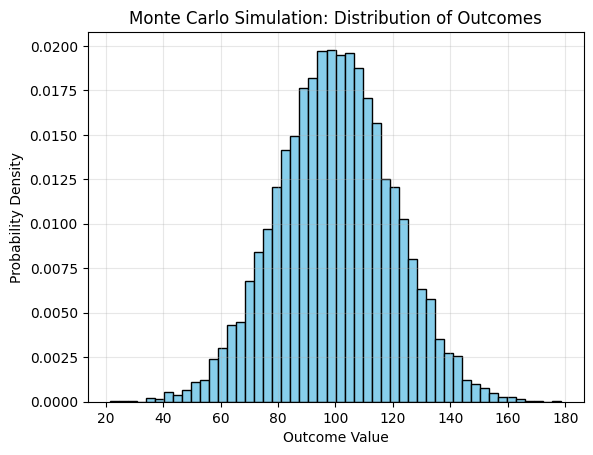

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate 10,000 random outcomes (e.g., profits)
np.random.seed(42)  # For reproducibility
outcomes = np.random.normal(loc=100, scale=20, size=10000)  # Mean=100, Std=20

# Create histogram
plt.hist(outcomes, bins=50, density=True, color='skyblue', edgecolor='black')
plt.title('Monte Carlo Simulation: Distribution of Outcomes')
plt.xlabel('Outcome Value')
plt.ylabel('Probability Density')
plt.grid(True, alpha=0.3)
plt.show()

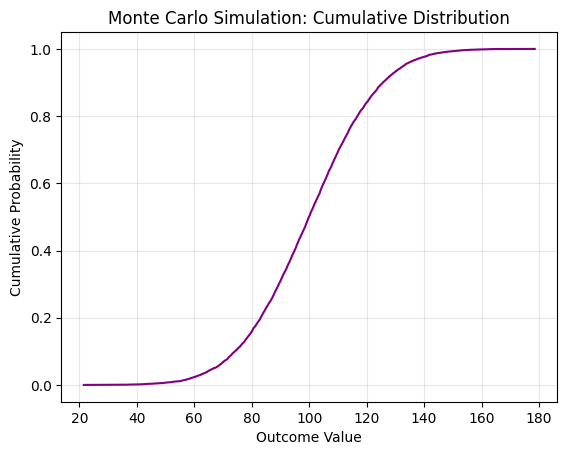

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Same simulation data
np.random.seed(42)
outcomes = np.random.normal(loc=100, scale=20, size=10000)

# Sort outcomes and compute cumulative probability
sorted_outcomes = np.sort(outcomes)
cumulative_prob = np.arange(1, len(outcomes) + 1) / len(outcomes)

# Plot
plt.plot(sorted_outcomes, cumulative_prob, color='purple')
plt.title('Monte Carlo Simulation: Cumulative Distribution')
plt.xlabel('Outcome Value')
plt.ylabel('Cumulative Probability')
plt.grid(True, alpha=0.3)
plt.show()

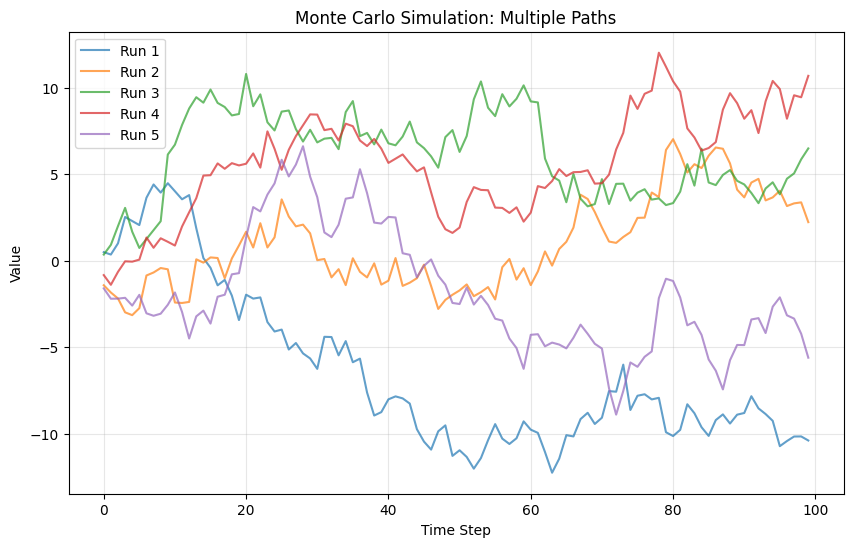

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate 5 paths over 100 time steps
np.random.seed(42)
n_steps = 100
n_simulations = 5
paths = np.zeros((n_simulations, n_steps))
for i in range(n_simulations):
    paths[i] = np.cumsum(np.random.normal(0, 1, n_steps))  # Random walk

# Plot
plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.plot(paths[i], label=f'Run {i+1}', alpha=0.7)
plt.title('Monte Carlo Simulation: Multiple Paths')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

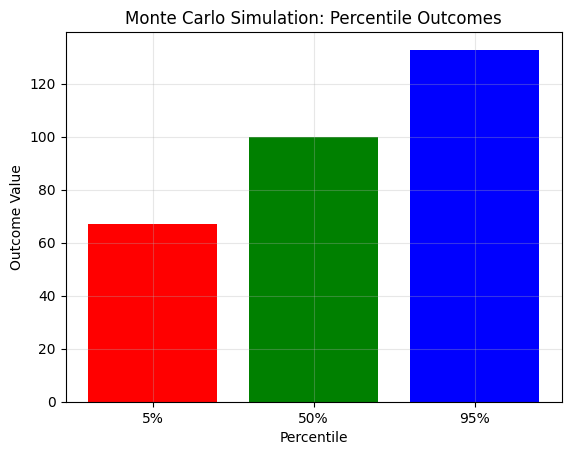

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Same simulation data
np.random.seed(42)
outcomes = np.random.normal(loc=100, scale=20, size=10000)

# Calculate percentiles
percentiles = [5, 50, 95]
values = np.percentile(outcomes, percentiles)

# Plot
plt.bar([f'{p}%' for p in percentiles], values, color=['red', 'green', 'blue'])
plt.title('Monte Carlo Simulation: Percentile Outcomes')
plt.xlabel('Percentile')
plt.ylabel('Outcome Value')
plt.grid(True, alpha=0.3)
plt.show()